# Analyze population data from https://covidtracking.com


**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML
from IPython import get_ipython

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd

In [2]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrJSON   import *
    from lib.DataMgr       import *
    from lib.pandaUtils    import *
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [5]:
checkSetup(chap="Chap04")
ImgMgr = ImageMgr(chapdir="Chap04")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../dataUSCovidTrack`.

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. Files of interest are documented in `.filespecs.json`

Consulted: https://github.com/COVID19Tracking/covid-tracking-api
  
Downloaded: see `.filespecs.json`
  
 

In [6]:
dataFileVMgr = manageAndCacheFilesJSONHandwritten("../dataUSCovidTrack")

In [7]:
dataFileVMgr.getRemoteInfo()
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

In [8]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent() :
    print(f"\t{f}")

Most recent versions of files in data directory:


In [9]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=True)

This ensures we load the most recent version, so that it is not required to update the list 
below. The timestamps shown in the following sequence will be update by the call to `getRecentVersion`.

In [10]:
USStatesDailyCSV    = last('CTStatesDaily.csv' ) 
USStatesInfoCSV     = last('CTStatesInfo.csv')
USDailyCSV          = last('CTUSDaily.csv')

USAPopChangeCSV     =  last('USACensusPopchange.csv')  
USAPopChangeRankCSV =  last('USACensusPopchangeRanks.csv')

Now load the stuff

In [11]:
ad  = lambda x: "../dataUSCovidTrack/"+x

data_USStatesDaily    = read_csvPandas(ad(USStatesDailyCSV) , error_bad_lines=False, sep="," )
data_USStatesInfo     = read_csvPandas(ad(USStatesInfoCSV),   error_bad_lines=False, sep="," )
data_USDaily          = read_csvPandas(ad(USDailyCSV),        error_bad_lines=False, sep="," )
data_USAPopChange     = read_csvPandas(ad(USAPopChangeCSV) ,  error_bad_lines=False, sep="," )
data_USAPopChangeRank = read_csvPandas(ad(USAPopChangeRankCSV), error_bad_lines=False, sep="," )

Show the shape of the loaded data:

In [12]:
def showBasics(data,dataName):
    print(f"{dataName:24}\thas shape {data.shape}")

dataListDescr = ( (data_USStatesDaily, "data_USStatesDaily"),
                  (data_USStatesInfo,  "data_USStatesInfo"),
                  (data_USDaily ,      "data_USDaily"),
                  (data_USAPopChange,  "data_USAPopChange"),
                  (data_USAPopChangeRank, "data_USAPopChangeRank"),
                )
    
for (dat,name) in dataListDescr:
    showBasics(dat,name)


data_USStatesDaily      	has shape (5337, 35)
data_USStatesInfo       	has shape (56, 11)
data_USDaily            	has shape (139, 25)
data_USAPopChange       	has shape (57, 151)
data_USAPopChangeRank   	has shape (57, 67)


In [13]:
for (dat,name) in dataListDescr:
    if name[0:5]=="meta_": continue
    print(f"\nDescription of data in '{name}'\n")
    display(dat.describe().transpose())


Description of data in 'data_USStatesDaily'



,count,mean,std,min,25%,50%,75%,max
date,5337.0,2.020044e+07,93.926847,20200122.0,20200329.00,20200422.0,20200516.00,20200608.0
positive,5322.0,1.515398e+04,39619.650959,0.0,213.00,2536.0,12644.25,378799.0
negative,5122.0,1.044035e+05,212525.057607,0.0,4425.25,32038.0,112683.50,2299871.0
pending,858.0,1.252469e+03,6562.085641,0.0,11.25,69.0,477.00,64400.0
hospitalizedCurrently,2775.0,1.135597e+03,2135.625482,1.0,104.00,403.0,1282.50,18825.0
hospitalizedCumulative,2463.0,3.842755e+03,12428.531207,0.0,173.00,740.0,2324.00,89995.0
inIcuCurrently,1458.0,4.935460e+02,763.094450,2.0,84.00,178.0,572.75,5225.0
inIcuCumulative,620.0,5.400968e+02,481.546731,6.0,145.00,360.5,876.00,1925.0
onVentilatorCurrently,1253.0,2.605778e+02,368.703176,0.0,30.00,94.0,292.00,2425.0
onVentilatorCumulative,214.0,1.368738e+02,88.588451,2.0,88.00,108.0,143.00,371.0



Description of data in 'data_USStatesInfo'



,count,mean,std,min,25%,50%,75%,max
fips,56.0,32.535714,19.075891,1.0,17.75,31.5,46.25,78.0
pui,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Description of data in 'data_USDaily'



,count,mean,std,min,25%,50%,75%,max
date,139.0,2.020036e+07,1.358599e+02,20200122.0,20200225.50,20200331.0,20200504.50,20200608.0
states,139.0,3.839568e+01,2.506647e+01,1.0,1.00,56.0,56.00,56.0
positive,139.0,5.802119e+05,6.742339e+05,1.0,2.00,192114.0,1186191.50,1952401.0
negative,101.0,5.294602e+06,5.577850e+06,14.0,388084.00,3135703.0,8937965.00,18662902.0
pending,97.0,1.107854e+04,1.788778e+04,103.0,1989.00,3455.0,14433.00,65709.0
hospitalizedCurrently,84.0,3.751527e+04,1.756851e+04,325.0,30753.50,41012.0,51901.25,59260.0
hospitalizedCumulative,80.0,1.183088e+05,6.835414e+04,1892.0,62548.75,121880.5,171160.50,217581.0
inIcuCurrently,75.0,9.594533e+03,3.614328e+03,1299.0,7511.50,9486.0,11958.50,15341.0
inIcuCumulative,76.0,4.406053e+03,3.094464e+03,74.0,1584.75,4343.0,7342.25,9013.0
onVentilatorCurrently,76.0,4.296105e+03,1.895018e+03,167.0,3668.00,4778.5,5634.50,7070.0



Description of data in 'data_USAPopChange'



,count,mean,std,min,25%,50%,75%,max
SUMLEV,57.0,3.807018e+01,6.391567e+00,10.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
STATE,57.0,2.717544e+01,1.812568e+01,0.000000,1.200000e+01,2.700000e+01,4.100000e+01,7.200000e+01
CENSUS2010POP,57.0,1.631513e+07,4.436075e+07,563626.000000,1.852994e+06,4.625364e+06,9.535483e+06,3.087455e+08
ESTIMATESBASE2010,57.0,1.631580e+07,4.436260e+07,563775.000000,1.853018e+06,4.625366e+06,9.535751e+06,3.087581e+08
POPESTIMATE2010,57.0,1.634538e+07,4.444586e+07,564487.000000,1.854239e+06,4.635649e+06,9.574323e+06,3.093217e+08
...,...,...,...,...,...,...,...,...
RNETMIG2015,57.0,2.312185e+00,6.155117e+00,-18.480599,-9.348537e-01,6.263574e-01,5.719232e+00,1.649149e+01
RNETMIG2016,57.0,2.228335e+00,6.690476e+00,-19.848533,-1.440045e+00,7.542736e-01,7.107500e+00,1.825830e+01
RNETMIG2017,57.0,1.859472e+00,7.092572e+00,-23.228903,-1.596256e+00,1.182732e+00,6.510551e+00,1.561639e+01
RNETMIG2018,57.0,1.232621e+00,7.766299e+00,-37.860351,-1.711806e+00,8.553821e-01,5.434037e+00,1.555981e+01



Description of data in 'data_USAPopChangeRank'



,count,mean,std,min,25%,50%,75%,max
SUMLEV,57.0,3.807018e+01,6.391567e+00,10.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
STATE,57.0,2.717544e+01,1.812568e+01,0.000000,1.200000e+01,2.700000e+01,4.100000e+01,7.200000e+01
ESTIMATESBASE2010,57.0,1.631580e+07,4.436260e+07,563775.000000,1.853018e+06,4.625366e+06,9.535751e+06,3.087581e+08
POPESTIMATE2010,57.0,1.634538e+07,4.444586e+07,564487.000000,1.854239e+06,4.635649e+06,9.574323e+06,3.093217e+08
POPESTIMATE2011,57.0,1.646227e+07,4.477654e+07,567299.000000,1.856301e+06,4.671994e+06,9.657592e+06,3.115569e+08
POPESTIMATE2012,57.0,1.658118e+07,4.511484e+07,576305.000000,1.856872e+06,4.717354e+06,9.749476e+06,3.138310e+08
POPESTIMATE2013,57.0,1.669428e+07,4.543594e+07,582122.000000,1.865279e+06,4.764080e+06,9.843336e+06,3.159937e+08
POPESTIMATE2014,57.0,1.681470e+07,4.578079e+07,582531.000000,1.879321e+06,4.823617e+06,9.929848e+06,3.183010e+08
POPESTIMATE2015,57.0,1.693647e+07,4.613239e+07,585613.000000,1.891277e+06,4.852347e+06,9.931715e+06,3.206352e+08
POPESTIMATE2016,57.0,1.705668e+07,4.647905e+07,584215.000000,1.905616e+06,4.863525e+06,9.950571e+06,3.229413e+08


In [14]:
for (dat,name) in dataListDescr:
    if name[0:5]=="meta_": continue
    print(f"\nInformation about '{name}'\n")
    dat.info()


Information about 'data_USStatesDaily'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      5337 non-null   int64  
 1   state                     5337 non-null   object 
 2   positive                  5322 non-null   float64
 3   negative                  5122 non-null   float64
 4   pending                   858 non-null    float64
 5   hospitalizedCurrently     2775 non-null   float64
 6   hospitalizedCumulative    2463 non-null   float64
 7   inIcuCurrently            1458 non-null   float64
 8   inIcuCumulative           620 non-null    float64
 9   onVentilatorCurrently     1253 non-null   float64
 10  onVentilatorCumulative    214 non-null    float64
 11  recovered                 2593 non-null   float64
 12  dataQualityGrade          4236 non-null   object 
 13  lastUpdateEt          

### Get demographics information
The metadata is in `../dataUSCovidTrack/*.pdf`. We need to preprocess the demographics information for ease of use below. Notice that column `STATE` features state's **FIPS codes**.

In [15]:
demogrCols=("SUMLEV","STATE","NAME","POPESTIMATE2019" )
demogrX = data_USAPopChange.loc[:,demogrCols]
demogrX["SUMLEV"]== 40
demogr = demogrX[demogrX["SUMLEV"]== 40 ].copy() 

In [16]:
dtCols = ('date','fips', 'state', 
          'positive', 'negative', 
          'hospitalizedCurrently', 'hospitalizedCumulative', 
          'inIcuCurrently', 'inIcuCumulative',
          'onVentilatorCurrently', 'onVentilatorCumulative', 
          'recovered','death', 'hospitalized'
         )

In [17]:
dt  = data_USStatesDaily.loc[ :, dtCols].copy()
dt["dateNum"] = PAN.to_datetime(dt.loc[:,"date"], format="%Y%m%d")
dateStart = dt["dateNum"].min()
dateEnd   = dt["dateNum"].max() 
dateSpan  = dateEnd - dateStart 
print(f"Our statistics span {dateSpan.days+1} days, start: {dateStart} and end {dateEnd}")
dt["elapsedDays"] = (dt["dateNum"] - dateStart).dt.days

dt = dt.set_index("state")
dtg = dt.groupby("state")

#dtx = dt[dt.index == "Europe"]
#dtg = dtx.groupby("countriesAndTerritories")

Our statistics span 139 days, start: 2020-01-22 00:00:00 and end 2020-06-08 00:00:00


Now, the figure making process is generalized into this class, since we plan to emit multiple figures.

In [18]:
class perStateFigure(object):
    """ This permits to make figures of data organized by State, it is expected that derived classes
        will bring different selections and orderings; further parametrization is also envisionned
    """
    def __init__(self, dateStart):
        self.dateStart = dateStart

    def initPainter(self, subnodeSpec=None, figsize=(15,15), maxCol=6, colFirst=False):
        if subnodeSpec is None:
            subnodeSpec = self.subnodeSpec
        elif isinstance(subnodeSpec,int):
            self.subnodeSpec = (lambda i,j:{"nrows":i,"ncols":j}) \
                                       (*subPlotShape( subnodeSpec, maxCol=maxCol,
                                                       colFirst=colFirst))
            subnodeSpec = self.subnodeSpec
            
        self.painter = figureFromFrame(None, subplots=subnodeSpec, figsize=figsize)

    def skipIfCond(self, count, state):
        return False

    def breakIfCond(self, count, state):
        return count > 15

    def getPop(self, state, dfx, doPrint=True):
            # get the population for the state (plus state name)
            fips = dfx.iloc[0,:].loc["fips"]
            demox = demogr.loc[demogr ["STATE"] == fips, :]
            if demox.shape[0] < 1:
                print(f"Issue with state encoding: state={state}")  
                self.abbrevIssueList.append(state)
                stName = None
                stPop  = None
            else:
                stName = demox.loc[:, "NAME"].iloc[0]
                stPop = demox.loc[:, "POPESTIMATE2019"].iloc[0]
            if doPrint:
                print(f"state={state}:{stName} fips={fips} pop={stPop}")
            return (stName, stPop, fips)
        
    def getPopStateTble(self,  groupedDF):
        data = []
        for (state, dfExtractOrig) in groupedDF:
            stName, stPop, fips = self.getPop(state, dfExtractOrig, doPrint=False)
            data.append( (state, stName, stPop, fips) )
            
        df = PAN.DataFrame(data, columns=("state","stName","pop","fips" ))
        return df
        
    def mkImage(self, groupedDF, plotCols):
        count = 0
        self.abbrevIssueList=[]
        
        for (state, dfExtractOrig) in groupedDF:
            count+=1
            if self.skipIfCond(count, state):
                continue
            if self.breakIfCond(count, state):
                break
            
            stName, stPop, fips = self.getPop(state, dfExtractOrig)
            if stPop is None:
                continue

            dfExtract = dfExtractOrig.set_index("elapsedDays").copy()

            for c in plotCols:
                dfExtract.loc[:,c] = dfExtract.loc[:,c]/stPop*1.0e6

            self.painter.doPlot(df = dfExtract.loc[:, plotCols] )
            self.painter.setAttrs(label=f"Days since {self.dateStart}",
                         title=f"Data from USA CovidTracking: {stName}",
                         legend=True,
                         xlabel=f"Days since {self.dateStart}",
                         ylabel="Events per million population"   )
        
            self.painter.advancePlotIndex()  

First attempt, just get the first!

state=AK:Alaska fips=2 pop=731545
state=AL:Alabama fips=1 pop=4903185
state=AR:Arkansas fips=5 pop=3017804
Issue with state encoding: state=AS
state=AS:None fips=60 pop=None
state=AZ:Arizona fips=4 pop=7278717
state=CA:California fips=6 pop=39512223
state=CO:Colorado fips=8 pop=5758736
state=CT:Connecticut fips=9 pop=3565287
state=DC:District of Columbia fips=11 pop=705749
state=DE:Delaware fips=10 pop=973764
state=FL:Florida fips=12 pop=21477737
state=GA:Georgia fips=13 pop=10617423
Issue with state encoding: state=GU
state=GU:None fips=66 pop=None
state=HI:Hawaii fips=15 pop=1415872
state=IA:Iowa fips=19 pop=3155070
Saving figure FIG001
Had issues with state encodings:['AS', 'GU']


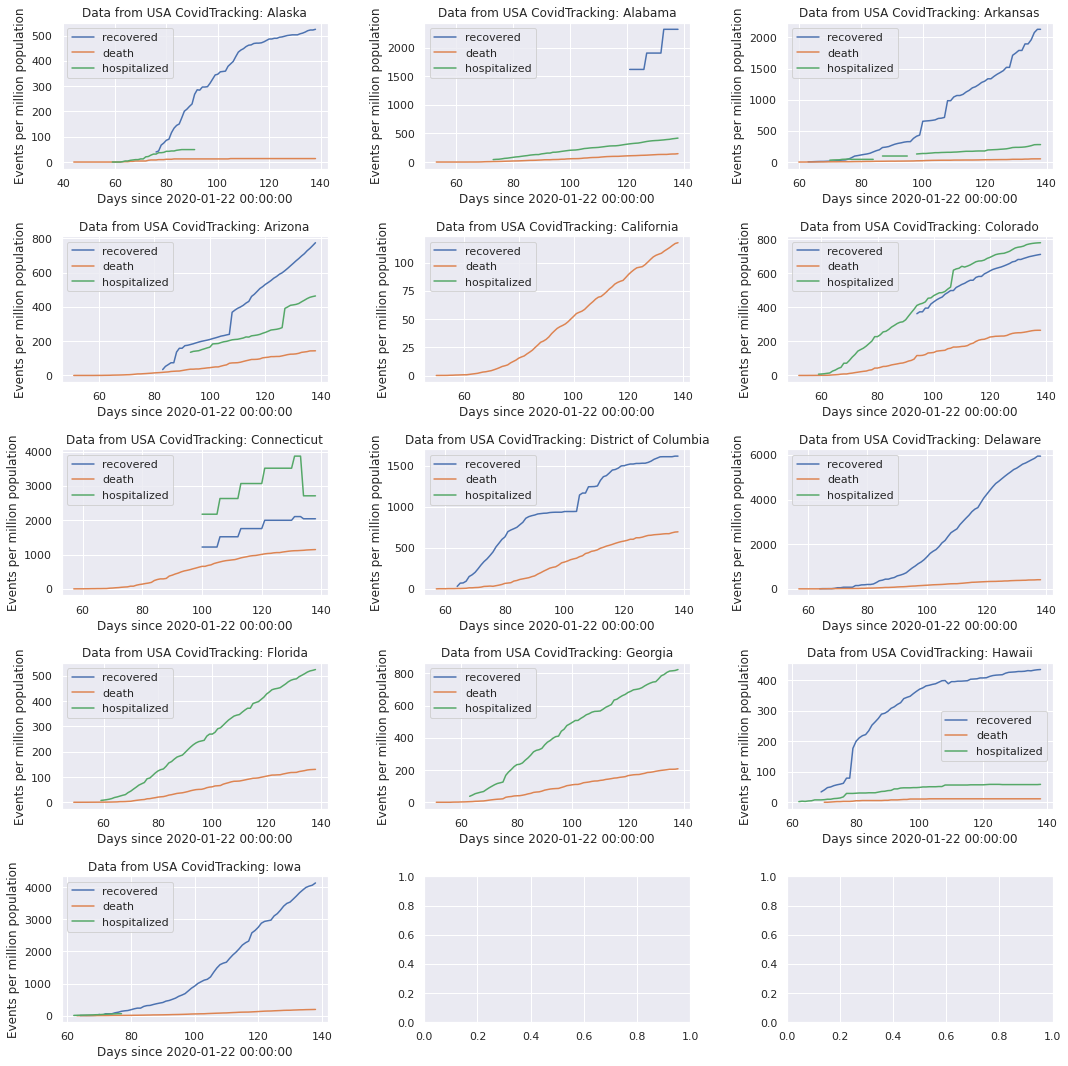

In [19]:
plotCols=("recovered","death","hospitalized")

psFig =  perStateFigure(dateStart)
psFig.initPainter(subnodeSpec=15, maxCol=3)
psFig.mkImage(dtg,plotCols)
ImgMgr.save_fig("FIG001")
print(f"Had issues with state encodings:{psFig.abbrevIssueList}")

## Now select  States  according to multiple criteria
### Start with most populated states

In [20]:
tble = psFig.getPopStateTble(dtg)

Issue with state encoding: state=AS
Issue with state encoding: state=GU
Issue with state encoding: state=MP
Issue with state encoding: state=VI


In [21]:
mostPopulated = tble.sort_values(by=["pop"], ascending=False,).iloc[:15,0].values

In [22]:
class perStateSelected(perStateFigure):
    def __init__(self, dateStart, select):
        perStateFigure.__init__(self, dateStart)
        self.selected = select
        
    def skipIfCond(self, count, state):
        return state not in self.selected
    
    def breakIfCond(self, count, state):
        return False

state=AZ:Arizona fips=4 pop=7278717
state=CA:California fips=6 pop=39512223
state=FL:Florida fips=12 pop=21477737
state=GA:Georgia fips=13 pop=10617423
state=IL:Illinois fips=17 pop=12671821
state=MA:Massachusetts fips=25 pop=6892503
state=MI:Michigan fips=26 pop=9986857
state=NC:North Carolina fips=37 pop=10488084
state=NJ:New Jersey fips=34 pop=8882190
state=NY:New York fips=36 pop=19453561
state=OH:Ohio fips=39 pop=11689100
state=PA:Pennsylvania fips=42 pop=12801989
state=TX:Texas fips=48 pop=28995881
state=VA:Virginia fips=51 pop=8535519
state=WA:Washington fips=53 pop=7614893
Saving figure FIG002
Had issues with state encodings:[]


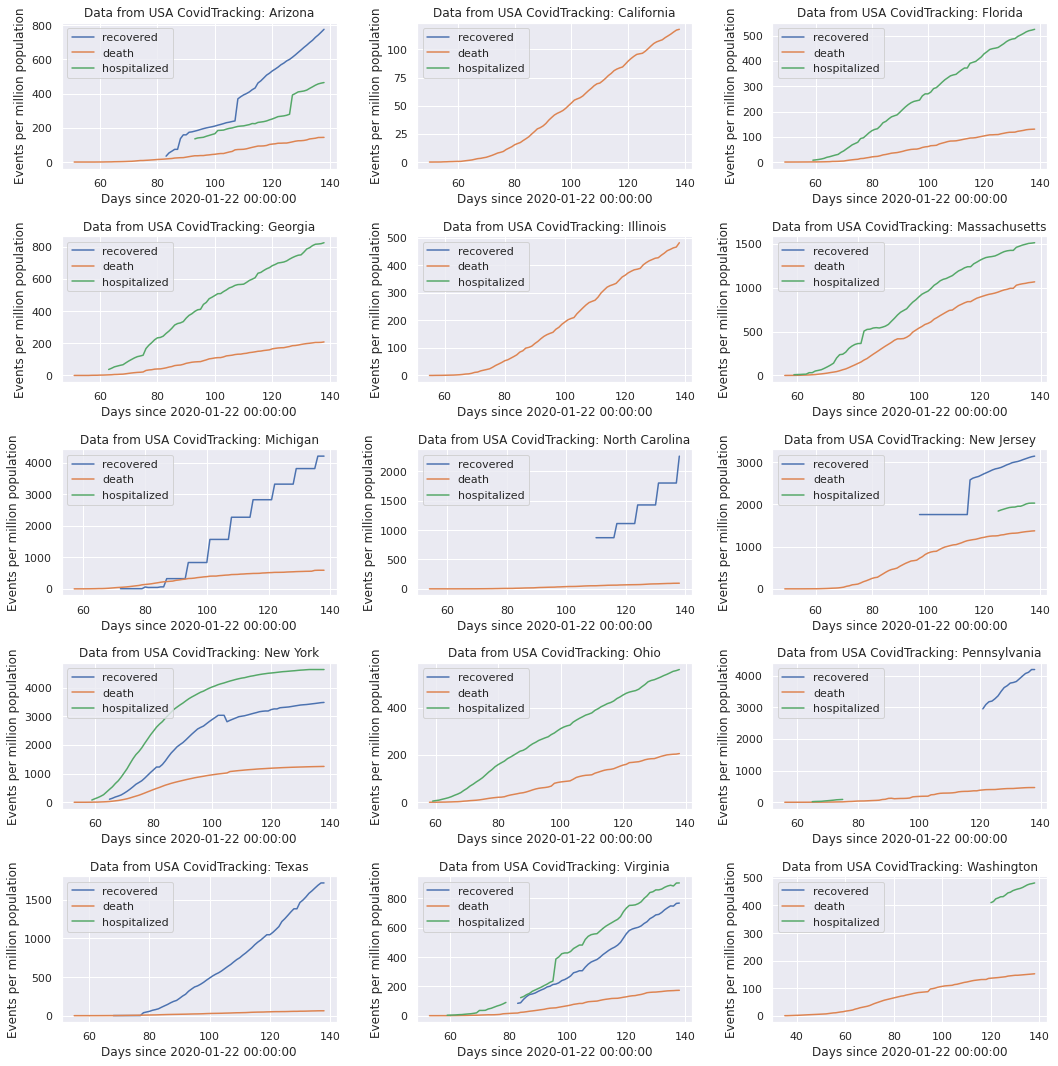

In [23]:
psFig2 =  perStateSelected(dateStart,mostPopulated)
psFig2.initPainter(subnodeSpec=15, maxCol=3)
psFig2.mkImage(dtg,plotCols)
ImgMgr.save_fig("FIG002")
print(f"Had issues with state encodings:{psFig2.abbrevIssueList}")

In [24]:
dtgMax = dtg.max().loc[:,["fips","death","recovered","hospitalized"]]

dtgMerged = PAN.merge(dtgMax.reset_index(), demogr, left_on="fips", right_on="STATE")
dtgMerged["deathPM"]= dtgMerged.loc[:,"death"]/dtgMerged.loc[:,"POPESTIMATE2019"]*1.0e6

mostDeadly = dtgMerged.sort_values(by=["deathPM"], ascending=False,).iloc[:15,0].values

state=CO:Colorado fips=8 pop=5758736
state=CT:Connecticut fips=9 pop=3565287
state=DC:District of Columbia fips=11 pop=705749
state=DE:Delaware fips=10 pop=973764
state=IL:Illinois fips=17 pop=12671821
state=IN:Indiana fips=18 pop=6732219
state=LA:Louisiana fips=22 pop=4648794
state=MA:Massachusetts fips=25 pop=6892503
state=MD:Maryland fips=24 pop=6045680
state=MI:Michigan fips=26 pop=9986857
state=MS:Mississippi fips=28 pop=2976149
state=NJ:New Jersey fips=34 pop=8882190
state=NY:New York fips=36 pop=19453561
state=PA:Pennsylvania fips=42 pop=12801989
state=RI:Rhode Island fips=44 pop=1059361
Saving figure FIG003
Had issues with state encodings:[]


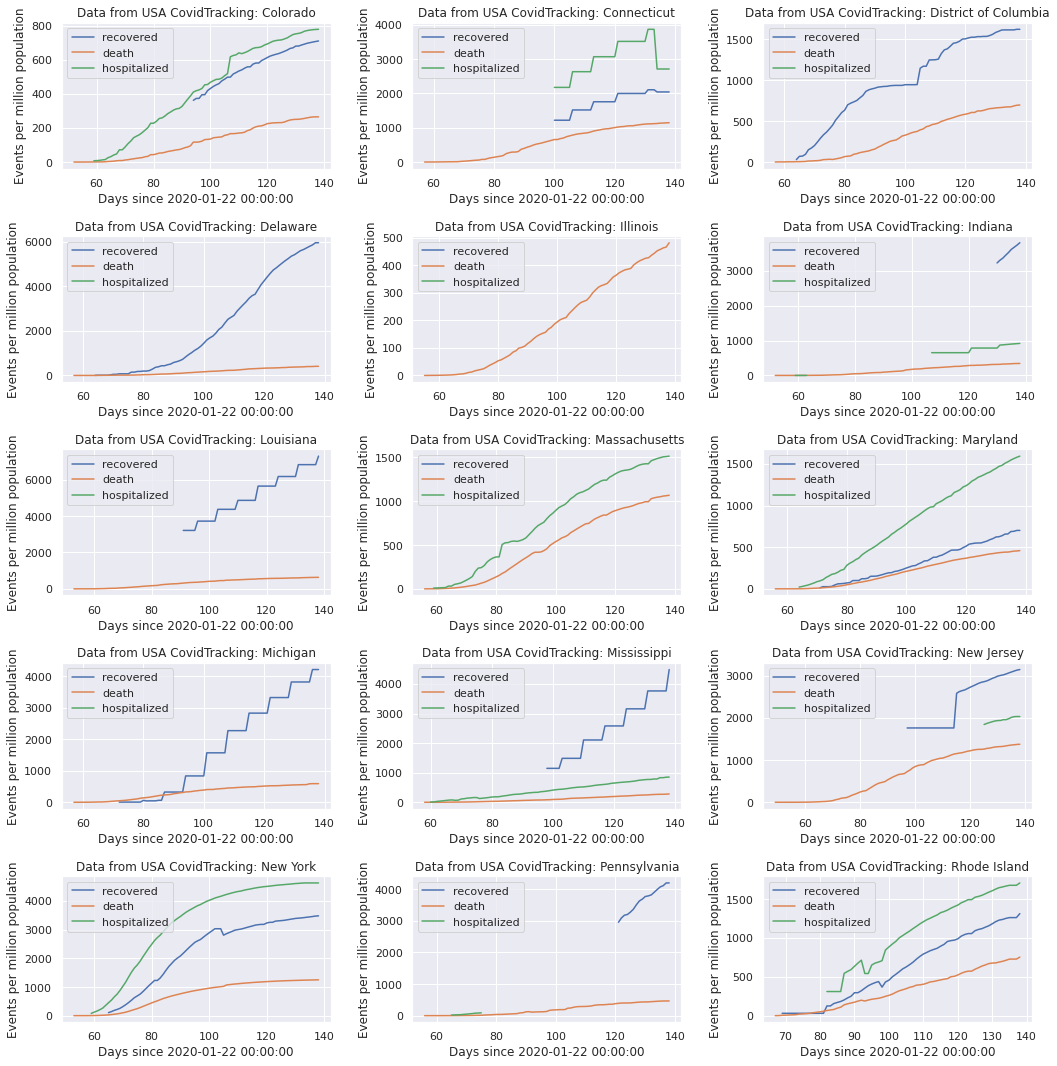

In [25]:
psFig3 =  perStateSelected(dateStart,mostDeadly)
psFig3.initPainter(subnodeSpec=15, maxCol=3)
psFig3.mkImage(dtg,plotCols)
ImgMgr.save_fig("FIG003")
print(f"Had issues with state encodings:{psFig3.abbrevIssueList}")